In [49]:
# --- Cell 1 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Konfigurasi agar hasil reproducible (Konsisten)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Library berhasil di-import dan Random Seed ditetapkan.")

Library berhasil di-import dan Random Seed ditetapkan.


In [50]:
df = pd.read_csv('Dry_Bean.csv')


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [52]:
df.isnull().sum()

,0
Area,0
Perimeter,0
MajorAxisLength,0
MinorAxisLength,0
AspectRation,0
Eccentricity,0
ConvexArea,0
EquivDiameter,0
Extent,0
Solidity,0


In [53]:
X = df.drop(columns=['Class'])
y = df['Class']


print(f"Dimensi Fitur (X): {X.shape}")
print(f"Dimensi Target (y): {y.shape}")

Dimensi Fitur (X): (13611, 16)
Dimensi Target (y): (13611,)


/tmp/ipython-input-2726382658.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Class', order=order_class, palette='viridis')


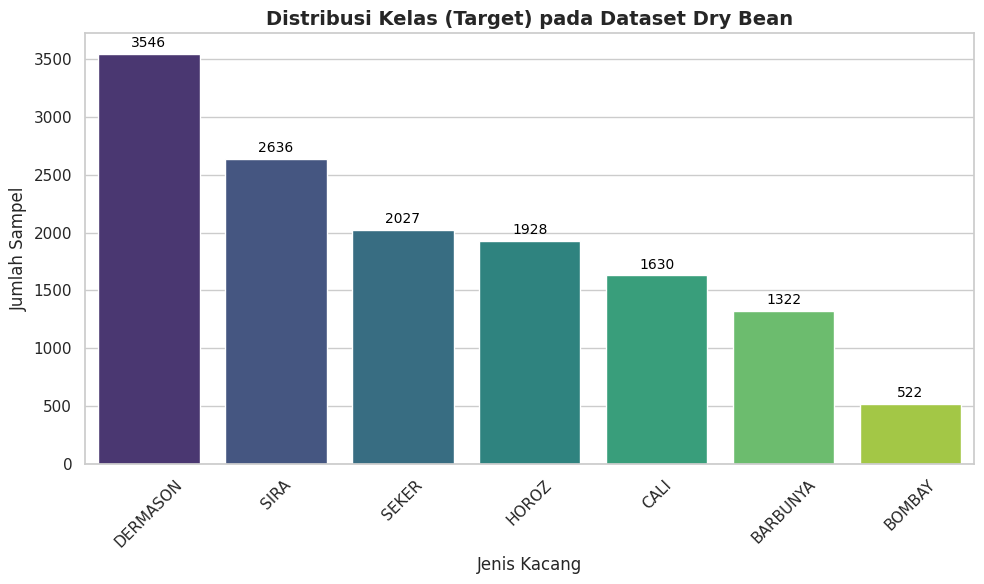

In [54]:
# Mengatur style plot agar lebih rapi
sns.set(style="whitegrid")

# ==========================================
# 1. Visualisasi Distribusi Kelas (Target)
# ==========================================
plt.figure(figsize=(10, 6))
# Mengurutkan berdasarkan jumlah terbanyak agar lebih rapi
order_class = df['Class'].value_counts().index
ax = sns.countplot(data=df, x='Class', order=order_class, palette='viridis')

plt.title('Distribusi Kelas (Target) pada Dataset Dry Bean', fontsize=14, fontweight='bold')
plt.xlabel('Jenis Kacang', fontsize=12)
plt.ylabel('Jumlah Sampel', fontsize=12)
plt.xticks(rotation=45) # Memutar label agar tidak bertumpuk

# Menambahkan angka detail di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

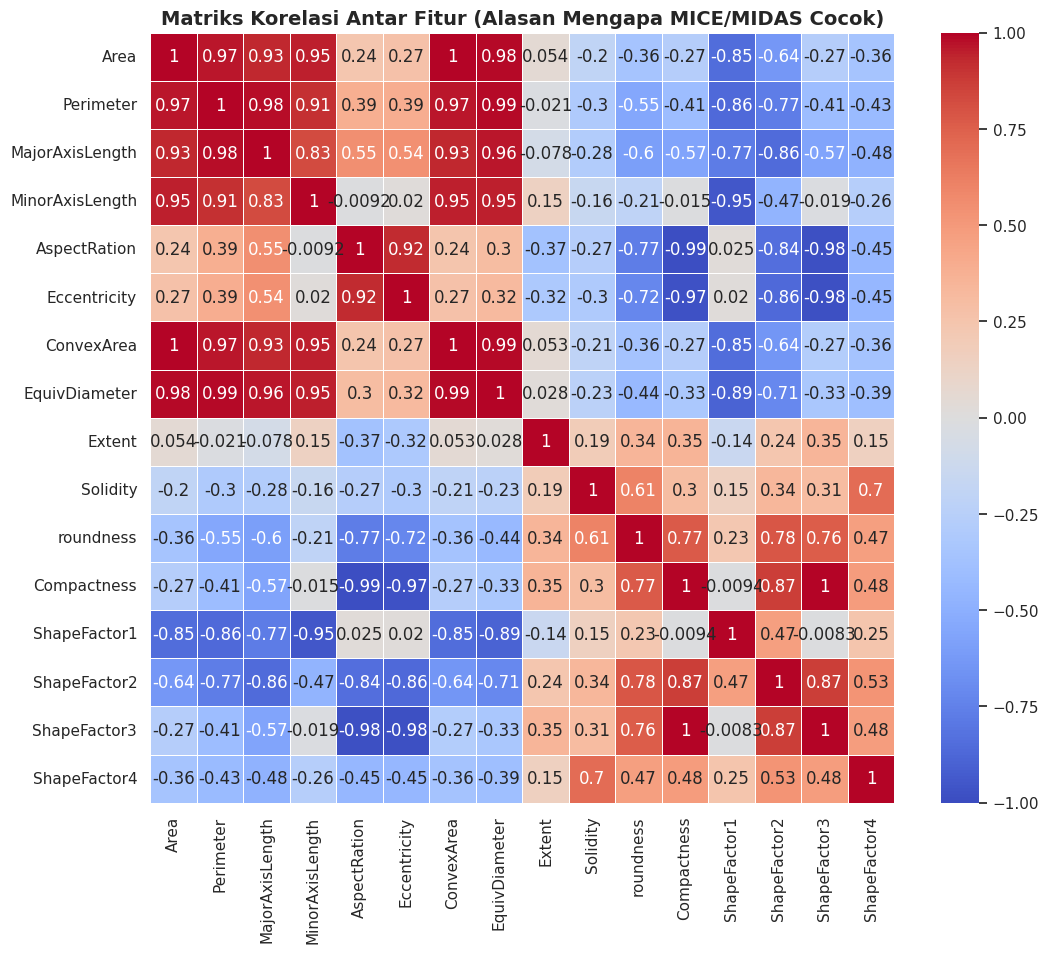

In [55]:
df_numeric = df.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,       # Set True jika ingin melihat angkanya (bisa agak penuh)
            cmap='coolwarm',   # Warna Merah = Korelasi Positif, Biru = Negatif
            linewidths=0.5,
            vmin=-1, vmax=1)   # Batas skala korelasi -1 sampai 1

plt.title('Matriks Korelasi Antar Fitur (Alasan Mengapa MICE/MIDAS Cocok)', fontsize=14, fontweight='bold')
plt.show()

In [56]:
# Simpan y (Target) di variabel terpisah, tidak akan diganggu gugat sampai Tahap Evaluasi Klasifikasi
y_ground_truth = y.copy()

# Inisialisasi Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit dan Transform pada X
# Kita menggunakan DataFrame wrapper agar nama kolom tetap terjaga (penting untuk analisis)
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)

print("Statistik Deskriptif Data setelah Scaling (Min-Max):")
display(X_scaled.describe().loc[['min', 'max', 'mean']])

Statistik Deskriptif Data setelah Scaling (Min-Max):


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
min,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.13932,0.226304,0.245905,0.23619,0.397295,0.768181,0.136386,0.224978,0.62538,0.900112,0.765693,0.459403,0.493356,0.371445,0.413253,0.910285


In [57]:
# --- Cell 8 ---
# --- Tahap III: Implementasi MIDAS (Adapted to PyTorch) ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Deteksi GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"MIDAS akan berjalan pada device: {device}")

class MidasPyTorch(nn.Module):
    def __init__(self, input_dim, layer_structure=[256, 256, 256], input_drop=0.8, dropout_level=0.5):
        """
        Re-implementasi logika MIDAS menggunakan PyTorch.
        Referensi: midas_base.py
        - Layer Structure default: [256, 256, 256]
        - Activation: ELU (Exponential Linear Unit)
        - Initialization: Xavier/Glorot (Pytorch default untuk Linear)
        """
        super(MidasPyTorch, self).__init__()

        self.input_dim = input_dim

        # --- 1. Encoder ---
        # Input Layer -> Hidden 1
        # MIDAS menggunakan input dropout yang tinggi (corruption)
        self.input_dropout = nn.Dropout(p=1.0 - input_drop) # Di PyTorch p adalah probabilitas drop

        self.enc_layer1 = nn.Linear(input_dim, layer_structure[0])
        self.enc_act1 = nn.ELU()
        self.enc_drop1 = nn.Dropout(p=dropout_level)

        # Hidden 1 -> Hidden 2
        self.enc_layer2 = nn.Linear(layer_structure[0], layer_structure[1])
        self.enc_act2 = nn.ELU()
        self.enc_drop2 = nn.Dropout(p=dropout_level)

        # --- 2. Decoder ---
        # Hidden 2 -> Hidden 3
        self.dec_layer1 = nn.Linear(layer_structure[1], layer_structure[2])
        self.dec_act1 = nn.ELU()
        self.dec_drop1 = nn.Dropout(p=dropout_level)

        # Hidden 3 -> Output
        self.output_layer = nn.Linear(layer_structure[2], input_dim)
        # Karena data kita MinMax Scaled [0, 1], kita gunakan Sigmoid di ujung
        # (MIDAS asli menggunakan ReLU untuk data positif, tapi Sigmoid lebih aman untuk data ternormalisasi)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        # Input Corruption (Denoising part)
        x_corrupt = self.input_dropout(x)

        # Encoding
        h1 = self.enc_act1(self.enc_layer1(x_corrupt))
        h1 = self.enc_drop1(h1)

        h2 = self.enc_act2(self.enc_layer2(h1))
        h2 = self.enc_drop2(h2)

        # Decoding
        h3 = self.dec_act1(self.dec_layer1(h2))
        h3 = self.dec_drop1(h3)

        out = self.output_layer(h3)
        out = self.output_act(out)

        return out

print("Arsitektur MidasPyTorch berhasil dibangun.")

MIDAS akan berjalan pada device: cuda
Arsitektur MidasPyTorch berhasil dibangun.


In [58]:
# --- Cell: Evaluasi Kualitas Imputasi (Mean vs MICE vs MIDAS) ---
from sklearn.metrics import mean_squared_error

# 1. --- PERSIAPAN DATA HASIL IMPUTASI ---

# A. Imputasi MEAN (Baseline)
# Mengisi NaN dengan rata-rata kolom
X_mean = X_missing.fillna(X_missing.mean())

In [59]:
# B. Imputasi MIDAS (Generate Output dari Model)
midas_model.eval() # Set mode evaluasi
with torch.no_grad():
    # Siapkan input: Data missing diisi 0 (sama seperti saat training)
    X_input_midas = X_missing.fillna(0).values
    X_tensor_midas = torch.tensor(X_input_midas, dtype=torch.float32).to(device)

    # Prediksi
    X_pred_midas = midas_model(X_tensor_midas).cpu().numpy()

    # Gabungkan: Ambil data asli yang ada, isi yang hilang dengan prediksi MIDAS
    # Menggunakan np.where untuk mengganti nilai NaN dengan prediksi MIDAS
    # np.where(condition, value_if_true, value_if_false)
    X_MIDAS_np = np.where(mask_matrix, X_pred_midas, X_missing.values)
    X_MIDAS = pd.DataFrame(X_MIDAS_np, columns=X_missing.columns)

In [60]:
# --- Cell A: Persiapan Variabel Global & Penampung Hasil ---

# List skenario missing rate yang akan diuji
SCENARIOS = [0.2, 0.5, 0.7]

# Dictionary untuk menyimpan skor RMSE (untuk grafik perbandingan nanti)
results_history = {
    'Missing_Rate': [],
    'Method': [],
    'RMSE': []
}

# Dictionary raksasa untuk menyimpan DataFrame hasil imputasi
# Struktur: imputed_datasets[0.2]['MICE'] -> akan berisi DataFrame hasil imputasi
imputed_datasets = {}

print("Persiapan variabel global selesai. Siap melakukan eksperimen multi-skenario.")

Persiapan variabel global selesai. Siap melakukan eksperimen multi-skenario.


In [61]:
# --- Cell B: Definisi Fungsi Helper ---

from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

def calculate_rmse(ground_truth, imputed_data, mask):
    """Menghitung RMSE hanya pada data yang hilang (masked)."""
    gt = ground_truth.values if hasattr(ground_truth, 'values') else ground_truth
    imp = imputed_data.values if hasattr(imputed_data, 'values') else imputed_data
    m = mask.values if hasattr(mask, 'values') else mask

    mse = mean_squared_error(gt[m], imp[m])
    return np.sqrt(mse)

def run_mean_imputation(X_miss):
    """Menjalankan Imputasi Mean."""
    return X_miss.fillna(X_miss.mean())

def run_mice_imputation(X_miss, random_state=42):
    """Menjalankan Imputasi MICE."""
    mice_imputer = IterativeImputer(estimator=BayesianRidge(),
                                    max_iter=20,
                                    random_state=random_state,
                                    tol=1e-3)
    X_mice_np = mice_imputer.fit_transform(X_miss)
    return pd.DataFrame(X_mice_np, columns=X_miss.columns)

print("Fungsi helper (RMSE, Mean, MICE) siap digunakan.")

Fungsi helper (RMSE, Mean, MICE) siap digunakan.


In [64]:
# --- Cell C (PERBAIKAN): Definisi Fungsi Wrapper MIDAS ---

def run_midas_imputation(X_miss, mask, epochs=50, lr=1e-4):
    """
    Melatih model MIDAS baru dari nol dan mengembalikan dataframe hasil imputasi.
    """
    # 1. Persiapan Data Loader
    X_filled_temp = X_miss.fillna(0).values

    # Konversi mask ke format MIDAS (1 = Observed/Ada, 0 = Missing)
    # Mask input kita: True=Missing, jadi harus di-negasi (~)
    if hasattr(mask, 'values'):
        mask_val = (~mask.values).astype(float) # Ambil .values agar jadi numpy
        mask_bool = mask.values # Simpan versi boolean numpy untuk nanti
    else:
        mask_val = (~mask).astype(float)
        mask_bool = mask

    tensor_x = torch.tensor(X_filled_temp, dtype=torch.float32).to(device)
    tensor_m = torch.tensor(mask_val, dtype=torch.float32).to(device)

    dataset = TensorDataset(tensor_x, tensor_m)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # 2. Inisialisasi Model Baru
    input_dim = X_miss.shape[1]
    model = MidasPyTorch(input_dim=input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 3. Training Loop
    model.train()
    for epoch in range(epochs):
        for bx, bm in dataloader:
            optimizer.zero_grad()
            out = model(bx)
            # Loss MIDAS: MSE pada data observed saja
            loss = ((out - bx)**2 * bm).sum() / (bm.sum() + 1e-9)
            loss.backward()
            optimizer.step()

    # 4. Generate Output (Imputasi)
    model.eval()
    with torch.no_grad():
        full_input = torch.tensor(X_filled_temp, dtype=torch.float32).to(device)
        full_pred = model(full_input).cpu().numpy()

        # --- PERBAIKAN DI BAGIAN INI (Menggunakan np.where) ---
        # Kita lakukan operasi level numpy agar tidak error shape mismatch
        X_miss_val = X_miss.values

        # Logika: Jika mask True (Missing), ambil dari Prediksi.
        # Jika False (Ada), ambil dari Data Asli.
        X_midas_numpy = np.where(mask_bool, full_pred, X_miss_val)

        # Kembalikan ke format DataFrame dengan nama kolom yang benar
        X_midas_imp = pd.DataFrame(X_midas_numpy, columns=X_miss.columns)

    return X_midas_imp

print("Fungsi helper MIDAS (Perbaikan np.where) siap digunakan.")

Fungsi helper MIDAS (Perbaikan np.where) siap digunakan.


In [65]:
# --- Cell D: EKSEKUSI UTAMA (Looping 20%, 50%, 70%) ---
import time

print("=== MEMULAI EXPERIMEN MULTI-SKENARIO ===")
start_total = time.time()

for rate in SCENARIOS:
    print(f"\n>> Sedang memproses Missing Rate: {rate*100}%...")
    imputed_datasets[rate] = {} # Bikin sub-dictionary

    # 1. Simulasi MCAR
    # Gunakan X_scaled (dari preprocessing awal)
    X_miss, mask = simulate_mcar(X_scaled, rate, random_state=42)

    # 2. Imputasi MEAN
    print("   Running Mean...", end="")
    X_mean = run_mean_imputation(X_miss)
    rmse_mean = calculate_rmse(X_scaled, X_mean, mask)

    results_history['Missing_Rate'].append(f"{int(rate*100)}%")
    results_history['Method'].append('Mean')
    results_history['RMSE'].append(rmse_mean)
    imputed_datasets[rate]['Mean'] = X_mean
    print(f" Done. (RMSE: {rmse_mean:.4f})")

    # 3. Imputasi MICE
    print("   Running MICE...", end="")
    X_mice = run_mice_imputation(X_miss)
    rmse_mice = calculate_rmse(X_scaled, X_mice, mask)

    results_history['Missing_Rate'].append(f"{int(rate*100)}%")
    results_history['Method'].append('MICE')
    results_history['RMSE'].append(rmse_mice)
    imputed_datasets[rate]['MICE'] = X_mice
    print(f" Done. (RMSE: {rmse_mice:.4f})")

    # 4. Imputasi MIDAS
    print("   Running MIDAS (Training)...", end="")
    X_midas = run_midas_imputation(X_miss, mask, epochs=50) # 50 Epoch cukup cepat
    rmse_midas = calculate_rmse(X_scaled, X_midas, mask)

    results_history['Missing_Rate'].append(f"{int(rate*100)}%")
    results_history['Method'].append('MIDAS')
    results_history['RMSE'].append(rmse_midas)
    imputed_datasets[rate]['MIDAS'] = X_midas
    print(f" Done. (RMSE: {rmse_midas:.4f})")

end_total = time.time()
print(f"\n=== SELESAI. Total Waktu: {end_total - start_total:.2f} detik ===")

=== MEMULAI EXPERIMEN MULTI-SKENARIO ===

>> Sedang memproses Missing Rate: 20.0%...
   Running Mean... Done. (RMSE: 0.1441)
   Running MICE...

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


 Done. (RMSE: 0.0422)
   Running MIDAS (Training)... Done. (RMSE: 0.0853)

>> Sedang memproses Missing Rate: 50.0%...
   Running Mean... Done. (RMSE: 0.1446)
   Running MICE... Done. (RMSE: 0.0598)
   Running MIDAS (Training)... Done. (RMSE: 0.1110)

>> Sedang memproses Missing Rate: 70.0%...
   Running Mean... Done. (RMSE: 0.1445)
   Running MICE... Done. (RMSE: 0.0887)
   Running MIDAS (Training)... Done. (RMSE: 0.1346)

=== SELESAI. Total Waktu: 282.45 detik ===


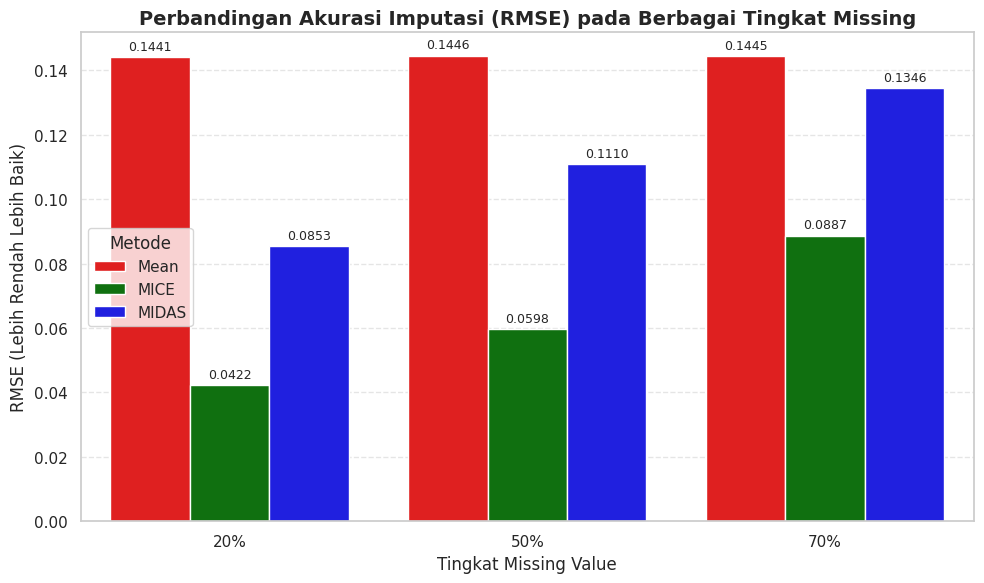


Struktur Data Tersimpan: dict_keys([0.2, 0.5, 0.7])


In [67]:
# --- Cell E: Visualisasi Perbandingan RMSE ---

df_results = pd.DataFrame(results_history)

plt.figure(figsize=(10, 6))

# Grouped Bar Plot
ax = sns.barplot(data=df_results, x='Missing_Rate', y='RMSE', hue='Method',
                 palette={'Mean': 'red', 'MICE': 'green', 'MIDAS': 'blue'})

plt.title('Perbandingan Akurasi Imputasi (RMSE) pada Berbagai Tingkat Missing', fontsize=14, fontweight='bold')
plt.xlabel('Tingkat Missing Value', fontsize=12)
plt.ylabel('RMSE (Lebih Rendah Lebih Baik)', fontsize=12)
plt.legend(title='Metode')

# Tampilkan angka
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Cek isi dictionary imputed_datasets untuk memastikan data tersimpan
print("\nStruktur Data Tersimpan:", imputed_datasets.keys())

In [69]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.2 MB/s eta 0:00:00


In [73]:
# --- Cell F (BARU): Definisi Logika Optuna ---
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Supaya log optuna tidak memenuhi layar
optuna.logging.set_verbosity(optuna.logging.WARNING)

def get_model_from_trial(trial, model_name):
    """
    Fungsi ini otomatis memilih parameter acak yang cerdas berdasarkan nama model.
    """
    if model_name == 'SVM':
        # C dicari dalam skala logaritmik (0.1, 1, 10, 100...)
        c_val = trial.suggest_float('C', 0.1, 100.0, log=True)
        kernel_val = trial.suggest_categorical('kernel', ['linear', 'rbf'])
        return SVC(C=c_val, kernel=kernel_val, random_state=42)

    elif model_name == 'DT':
        depth_val = trial.suggest_int('max_depth', 5, 50)
        split_val = trial.suggest_int('min_samples_split', 2, 20)
        return DecisionTreeClassifier(max_depth=depth_val, min_samples_split=split_val, random_state=42)

    elif model_name == 'RF':
        n_est = trial.suggest_int('n_estimators', 10, 200)
        depth_val = trial.suggest_int('max_depth', 5, 50)
        return RandomForestClassifier(n_estimators=n_est, max_depth=depth_val, random_state=42)

    elif model_name == 'KNN':
        k_val = trial.suggest_int('n_neighbors', 3, 20)
        w_val = trial.suggest_categorical('weights', ['uniform', 'distance'])
        return KNeighborsClassifier(n_neighbors=k_val, weights=w_val)

    elif model_name == 'LR':
        c_val = trial.suggest_float('C', 0.01, 100.0, log=True)
        return LogisticRegression(C=c_val, solver='lbfgs', max_iter=1000, random_state=42)

print("Logika Optuna siap.")

Logika Optuna siap.


In [74]:
# --- Cell G (BARU): Fungsi Eksekusi Optuna ---



def optimize_and_evaluate(X, y, model_name, n_trials=20):
    """
    Menjalankan pencarian parameter terbaik menggunakan Optuna (TPE Sampler).
    n_trials = Jumlah kesempatan (budget) yang diberikan ke setiap model.
    """
    # 1. Definisi Objective Function untuk Optuna
    def objective(trial):
        # Buat model dengan parameter yang disarankan trial saat ini
        model = get_model_from_trial(trial, model_name)

        # Evaluasi pakai Cross Validation (3-Fold) agar robust
        # Kita pakai Accuracy sebagai target optimasi
        scores = cross_val_score(model, X, y, cv=3, scoring='accuracy', n_jobs=-1)
        return scores.mean()

    # 2. Buat Studi Baru (Turnamen Pencarian)
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials) # Jalankan optimasi

    # 3. Ambil Parameter Terbaik Juara
    best_params = study.best_params

    # 4. Latih Ulang Model Final dengan Parameter Terbaik (80:20 Split Manual)
    #    Ini untuk mendapatkan skor akhir yang akan kita plot
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Re-create model terbaik
    # Kita perlu memparsing ulang best_params ke objek model
    # (Cara manual sedikit diperlukan di sini agar kompatibel dengan function get_model)

    # Trik: kita pakai FixedTrial untuk merekonstruksi model terbaik
    from optuna.trial import FixedTrial
    best_model = get_model_from_trial(FixedTrial(best_params), model_name)

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    return acc, f1, best_params

def run_default_model(X, y, model_name):
    """Fungsi sederhana untuk mode Default (Tanpa Tuning)"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Inisialisasi Default
    if model_name == 'SVM': model = SVC(random_state=42)
    elif model_name == 'DT': model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'RF': model = RandomForestClassifier(random_state=42)
    elif model_name == 'KNN': model = KNeighborsClassifier()
    elif model_name == 'LR': model = LogisticRegression(max_iter=1000, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')

print("Fungsi Optimizer Otomatis Siap.")

Fungsi Optimizer Otomatis Siap.


In [75]:
# --- Cell H (BARU): Eksekusi Klasifikasi dengan Optuna ---
import pandas as pd
from tqdm import tqdm

classification_results = {
    'Scenario': [], 'Imputation': [], 'Model': [],
    'Mode': [], 'Accuracy': [], 'F1_Score': []
}

MODELS_LIST = ['SVM', 'DT', 'RF', 'KNN', 'LR']
N_TRIALS = 15 # Budget keadilan: Setiap model dapat 15x percobaan tuning

print(f"=== MEMULAI TURNAMEN (Optuna Budget: {N_TRIALS} Trials/Model) ===")

# --- 1. EVALUASI BASELINE (CLEAN) ---
print("\n>> Evaluasi Baseline...")
for model_name in tqdm(MODELS_LIST):
    # Mode Default
    acc, f1 = run_default_model(X_scaled, y_ground_truth, model_name)
    classification_results['Scenario'].append('Baseline')
    classification_results['Imputation'].append('Original')
    classification_results['Model'].append(model_name)
    classification_results['Mode'].append('Default')
    classification_results['Accuracy'].append(acc)
    classification_results['F1_Score'].append(f1)

    # Mode Tuned (Optuna)
    acc, f1, _ = optimize_and_evaluate(X_scaled, y_ground_truth, model_name, n_trials=N_TRIALS)
    classification_results['Scenario'].append('Baseline')
    classification_results['Imputation'].append('Original')
    classification_results['Model'].append(model_name)
    classification_results['Mode'].append('Tuned')
    classification_results['Accuracy'].append(acc)
    classification_results['F1_Score'].append(f1)

# --- 2. EVALUASI IMPUTASI ---
for rate in SCENARIOS:
    print(f"\n>> Skenario Missing Rate {rate*100}%...")

    for method_name, X_imp in imputed_datasets[rate].items():
        print(f"   -> Metode: {method_name}")

        for model_name in MODELS_LIST:
            # Mode Default
            acc, f1 = run_default_model(X_imp, y_ground_truth, model_name)
            classification_results['Scenario'].append(f"{int(rate*100)}%")
            classification_results['Imputation'].append(method_name)
            classification_results['Model'].append(model_name)
            classification_results['Mode'].append('Default')
            classification_results['Accuracy'].append(acc)
            classification_results['F1_Score'].append(f1)

            # Mode Tuned (Optuna)
            acc, f1, _ = optimize_and_evaluate(X_imp, y_ground_truth, model_name, n_trials=N_TRIALS)
            classification_results['Scenario'].append(f"{int(rate*100)}%")
            classification_results['Imputation'].append(method_name)
            classification_results['Model'].append(model_name)
            classification_results['Mode'].append('Tuned')
            classification_results['Accuracy'].append(acc)
            classification_results['F1_Score'].append(f1)

df_clf_results = pd.DataFrame(classification_results)
print("\n=== SELESAI SEMUA ===")
display(df_clf_results.head())

=== MEMULAI TURNAMEN (Optuna Budget: 15 Trials/Model) ===

>> Evaluasi Baseline...


100%|██████████| 5/5 [04:50<00:00, 58.18s/it]



>> Skenario Missing Rate 20.0%...
   -> Metode: Mean
   -> Metode: MICE
   -> Metode: MIDAS

>> Skenario Missing Rate 50.0%...
   -> Metode: Mean
   -> Metode: MICE
   -> Metode: MIDAS

>> Skenario Missing Rate 70.0%...
   -> Metode: Mean
   -> Metode: MICE
   -> Metode: MIDAS

=== SELESAI SEMUA ===


,Scenario,Imputation,Model,Mode,Accuracy,F1_Score
0,Baseline,Original,SVM,Default,0.928388,0.939909
1,Baseline,Original,SVM,Tuned,0.922512,0.933587
2,Baseline,Original,DT,Default,0.892765,0.906986
3,Baseline,Original,DT,Tuned,0.875872,0.876973
4,Baseline,Original,RF,Default,0.925450,0.936352


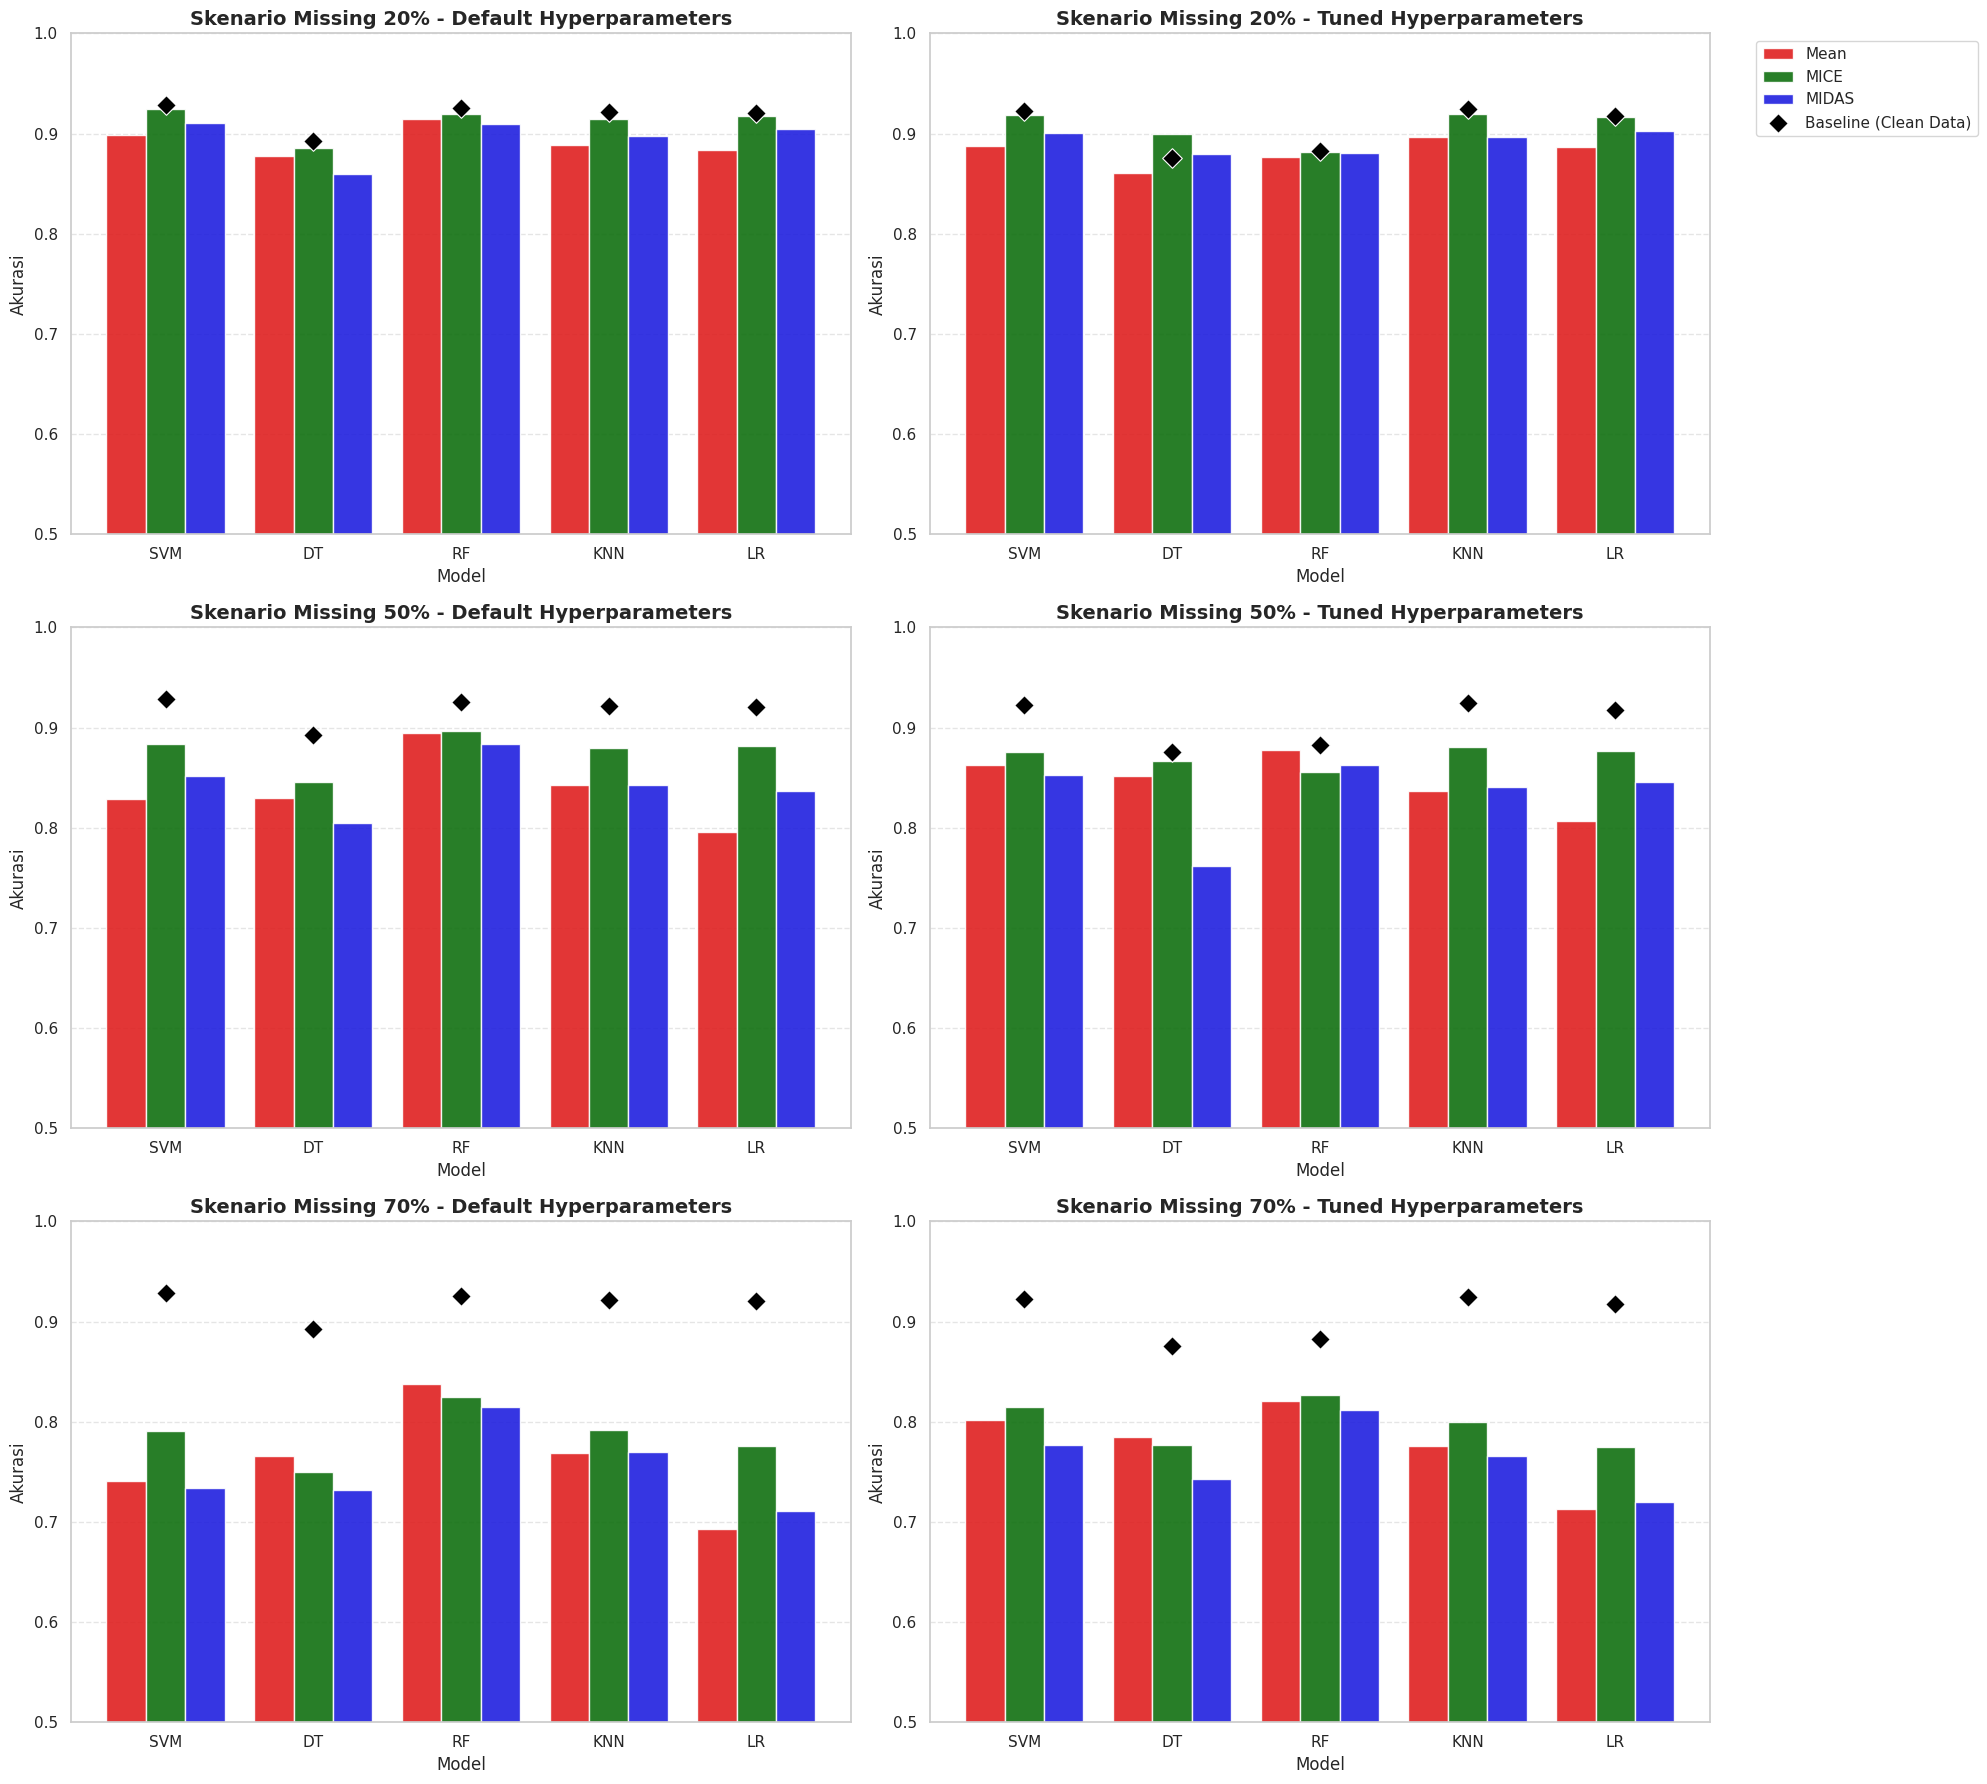

In [76]:
# --- Cell I: Visualisasi Komprehensif (6 Skenario) ---

def plot_classification_results(df_res):
    # Setup Grid 3 Baris x 2 Kolom
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))

    scenarios_rate = ['20%', '50%', '70%']
    modes_list = ['Default', 'Tuned']

    # Ambil nilai baseline rata-rata per model (untuk garis referensi)
    # Ini agak tricky, kita ambil rata-rata baseline accuracy per mode
    baseline_df = df_res[df_res['Scenario'] == 'Baseline']

    for i, rate in enumerate(scenarios_rate):
        for j, mode in enumerate(modes_list):
            ax = axes[i, j]

            # Filter data sesuai skenario
            subset = df_res[
                (df_res['Scenario'] == rate) &
                (df_res['Mode'] == mode)
            ]

            # Filter baseline sesuai mode
            base_subset = baseline_df[baseline_df['Mode'] == mode]

            # Bar Plot
            sns.barplot(data=subset, x='Model', y='Accuracy', hue='Imputation',
                        palette={'Mean': 'red', 'MICE': 'green', 'MIDAS': 'blue'},
                        ax=ax, alpha=0.9)

            # Tambahkan Garis Baseline (Data Clean)
            # Kita plot titik baseline untuk setiap model sebagai referensi
            # Menggunakan scatter plot di atas bar plot
            sns.scatterplot(data=base_subset, x='Model', y='Accuracy',
                            color='black', marker='D', s=100, zorder=5,
                            label='Baseline (Clean Data)', ax=ax)

            # Kosmetik Grafik
            ax.set_title(f'Skenario Missing {rate} - {mode} Hyperparameters', fontsize=14, fontweight='bold')
            ax.set_ylim(0.5, 1.0) # Fokus ke range 50% - 100% agar bedanya terlihat
            ax.set_ylabel('Akurasi')
            ax.grid(axis='y', linestyle='--', alpha=0.5)

            # Legenda hanya di plot pertama agar tidak penuh
            if i == 0 and j == 1:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                ax.legend().remove()

    plt.tight_layout()
    plt.show()

# Jalankan Plotting
plot_classification_results(df_clf_results)

JUARA UMUM TURNAMEN:
Skenario : Baseline
Metode   : Original
Model    : SVM
Mode     : Default
Akurasi  : 0.9284


<Figure size 1000x800 with 0 Axes>

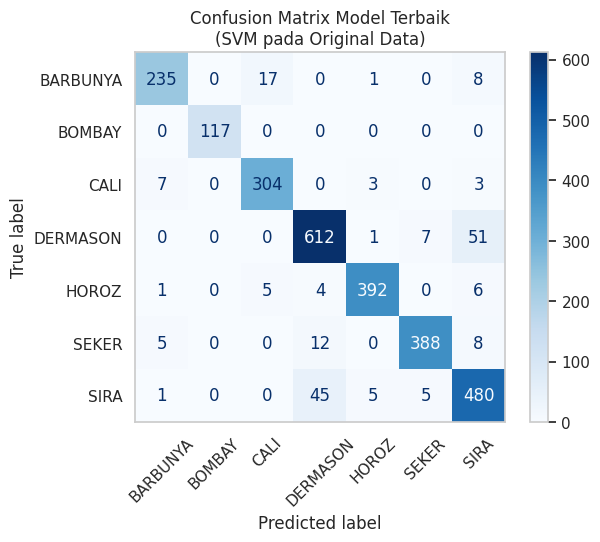

In [78]:
# --- Cell K: Deep Dive - Visualisasi Model Terbaik ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Cari Siapa Juara 1 dari seluruh eksperimen
best_row = df_clf_results.loc[df_clf_results['Accuracy'].idxmax()]
print(f"JUARA UMUM TURNAMEN:")
print(f"Skenario : {best_row['Scenario']}")
print(f"Metode   : {best_row['Imputation']}")
print(f"Model    : {best_row['Model']}")
print(f"Mode     : {best_row['Mode']}")
print(f"Akurasi  : {best_row['Accuracy']:.4f}")

# 2. Ambil Data yang sesuai dengan Juara
# (Kita perlu ambil manual dari dictionary imputed_datasets)
if best_row['Scenario'] == 'Baseline':
    X_final = X_scaled
    rate_title = "Original Data"
else:
    # Parsing string "50%" jadi float 0.5
    rate_float = float(best_row['Scenario'].strip('%')) / 100
    X_final = imputed_datasets[rate_float][best_row['Imputation']]
    rate_title = f"Imputasi {best_row['Imputation']} ({best_row['Scenario']} Missing)"

# 3. Latih Ulang Model Juara untuk plot Confusion Matrix
# (Kita pakai Default parameter biar cepat, atau best params kalau mau detail)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_ground_truth, test_size=0.2, random_state=42)

if best_row['Model'] == 'RF': clf = RandomForestClassifier(random_state=42)
elif best_row['Model'] == 'SVM': clf = SVC(random_state=42)
elif best_row['Model'] == 'KNN': clf = KNeighborsClassifier()
elif best_row['Model'] == 'DT': clf = DecisionTreeClassifier(random_state=42)
elif best_row['Model'] == 'LR': clf = LogisticRegression(max_iter=1000, random_state=42)

clf.fit(X_train, y_train)
y_pred_final = clf.predict(X_test)

# 4. Plot
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
plt.title(f'Confusion Matrix Model Terbaik\n({best_row['Model']} pada {rate_title})')
plt.grid(False)
plt.show()

In [77]:
# --- Cell J: Simpan Hasil ke CSV/Excel ---
# Simpan agar aman dan bisa dianalisis di Excel nanti
df_clf_results.to_csv('Hasil_Akhir_Klasifikasi_Turnamen.csv', index=False)
print("File 'Hasil_Akhir_Klasifikasi_Turnamen.csv' berhasil disimpan!")
print("Silakan download dari tab 'Files' di sebelah kiri Colab.")

File 'Hasil_Akhir_Klasifikasi_Turnamen.csv' berhasil disimpan!
Silakan download dari tab 'Files' di sebelah kiri Colab.
